In [1]:
!pip install transformers tokenizers datasets huggingface_hub --quiet

import numpy as np
import random
import os
import tensorflow as tf
from transformers import set_seed

rand_seed = 9

def seed_everything(seed=0):
    random.seed(seed) # random
    os.environ['PYTHONHASHSEED'] = str(seed) # python enviroment
    np.random.seed(seed) # numpy
    tf.keras.utils.set_random_seed(seed) # tensorflow
    tf.random.set_seed(seed) # tensorflow
    set_seed(seed) # hugging_face transformer

seed_everything(rand_seed)

###               --  0  --                       --  1  --                         --  2  --                    --  3  --
model_id = ['raygx/Nepali-DistilGPT2','raygx/Covid-News-Headline-Generator','raygx/Nepali-GPT2-CausalLM','Sakonii/distilgpt2-nepali'][2]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 75.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 95.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.2/486.2 kB 25.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.5/268.5 kB 23.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 55.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 22.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 14.6 MB/s eta 0:00:00


In [2]:
# from huggingface_hub import notebook_login
# notebook_login()

# Loading Model and Tokenizer

In [3]:
from transformers import TFAutoModelForSequenceClassification, PreTrainedTokenizerFast
import datasets

tokenizer = PreTrainedTokenizerFast.from_pretrained(model_id)
tokenizer

PreTrainedTokenizerFast(name_or_path='raygx/Nepali-GPT2-CausalLM', vocab_size=50000, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '[CLS]', 'eos_token': '[SEP]', 'pad_token': '[PAD]'}, clean_up_tokenization_spaces=True)

In [5]:
from transformers import AutoConfig
from transformers import BertTokenizerFast


config = AutoConfig.from_pretrained(
          model_id,
          bos_token_id=tokenizer.bos_token_id,
          eos_token_id=tokenizer.eos_token_id,
          pad_token_id=tokenizer.pad_token_id,
          id2label={0:"NEUTRAL",1:"POSITIVE",2:"NEGATIVE"},
          label2id={"NEUTRAL":0,"POSITIVE":1,"NEGATIVE":2}
        )


print("Intialization: Pretrained - {}".format(model_id))
model = TFAutoModelForSequenceClassification.from_pretrained(model_id,config = config)

model.resize_token_embeddings(len(tokenizer))

Intialization: Pretrained - raygx/Nepali-GPT2-CausalLM


All model checkpoint layers were used when initializing TFGPT2ForSequenceClassification.

Some layers of TFGPT2ForSequenceClassification were not initialized from the model checkpoint at raygx/Nepali-GPT2-CausalLM and are newly initialized: ['score']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [6]:
print(model.config)
print(model.summary())

GPT2Config {
  "_name_or_path": "raygx/Nepali-GPT2-CausalLM",
  "activation_function": "gelu_new",
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attn_pdrop": 0.1,
  "bos_token_id": 1,
  "embd_pdrop": 0.1,
  "eos_token_id": 2,
  "id2label": {
    "0": "NEUTRAL",
    "1": "POSITIVE",
    "2": "NEGATIVE"
  },
  "initializer_range": 0.02,
  "label2id": {
    "NEGATIVE": 2,
    "NEUTRAL": 0,
    "POSITIVE": 1
  },
  "layer_norm_epsilon": 1e-05,
  "model_type": "gpt2",
  "n_ctx": 1024,
  "n_embd": 768,
  "n_head": 12,
  "n_inner": null,
  "n_layer": 12,
  "n_positions": 1024,
  "pad_token_id": 3,
  "reorder_and_upcast_attn": false,
  "resid_pdrop": 0.1,
  "scale_attn_by_inverse_layer_idx": false,
  "scale_attn_weights": true,
  "summary_activation": null,
  "summary_first_dropout": 0.1,
  "summary_proj_to_labels": true,
  "summary_type": "cls_index",
  "summary_use_proj": true,
  "task_specific_params": {
    "text-generation": {
      "do_sample": true,
      "max_length": 50
    }
  }

In [1]:
# print(tokenizer("Hello World!",return_tensors='tf'))#, tokenizer.decode(tokenizer("Hello World!",return_tensors='tf')['input_ids']))
# model.transformer(tokenizer("Hello World!",return_tensors='tf'))

In [7]:
from transformers import create_optimizer, AdamWeightDecay
import tensorflow as tf

optimizer = AdamWeightDecay(learning_rate=1e-6, weight_decay_rate=0.0001)
model.compile(optimizer=optimizer)

# Data Loading and Preparation

In [8]:
if False:
  print("#######################Using NepCov19Tweets#########################")
  data = datasets.load_dataset("raygx/NepCov19Tweets")
elif False:
  print("####################Using NepCov19TweetsPlus########################")
  data = datasets.load_dataset("raygx/NepCov19TweetsPlus")
else:
  print("####################Using NepCov19TweetsPlus2########################")
  data = datasets.load_dataset("raygx/NepCov19TweetsPlus2")

data = data.rename_columns({"Sentiment":"labels","Sentences":"text"})
data

####################Using NepCov19TweetsPlus2########################


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/39432 [00:00<?, ? examples/s]

Dataset parquet downloaded and prepared to /root/.cache/huggingface/datasets/raygx___parquet/raygx--NepCov19TweetsPlus2-03e8540227dbc72f/0.0.0/14a00e99c0d15a23649d0db8944380ac81082d4b021f398733dd84f3a6c569a7. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['labels', 'text'],
        num_rows: 39432
    })
})

In [9]:
data = data.shuffle(999)
data = data['train'].train_test_split(test_size=0.2)
data

DatasetDict({
    train: Dataset({
        features: ['labels', 'text'],
        num_rows: 31545
    })
    test: Dataset({
        features: ['labels', 'text'],
        num_rows: 7887
    })
})

In [10]:
def prepareLabels(row):
    if row['labels'] == -1:
        row['labels'] = 2

    return row

data = data.map(
        prepareLabels,
        num_proc=4)

print(data)

Map (num_proc=4):   0%|          | 0/31545 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/7887 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['labels', 'text'],
        num_rows: 31545
    })
    test: Dataset({
        features: ['labels', 'text'],
        num_rows: 7887
    })
})


In [11]:
%%time

def preprocess_function(rows):
    return tokenizer(rows['text'],truncation=True)

print("Tokenizing the data")
tokenized_inputs = data.map(
    preprocess_function,
    batched=True,
    num_proc=2,
    remove_columns=data["train"].column_names,
)
tokenized_inputs = tokenized_inputs.remove_columns(['token_type_ids'])

tokenized_inputs['train'] = tokenized_inputs['train'].add_column(
    name="labels",column=data['train']['labels']
)
tokenized_inputs['test'] = tokenized_inputs['test'].add_column(
    name="labels",column=data['test']['labels']
)

tokenized_inputs

Tokenizing the data


Map (num_proc=2):   0%|          | 0/31545 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Map (num_proc=2):   0%|          | 0/7887 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


CPU times: user 397 ms, sys: 229 ms, total: 626 ms
Wall time: 7.86 s


DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 31545
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 7887
    })
})

In [12]:
print(data['train'][:1])
print(tokenized_inputs['train'][:1]['input_ids'])
print(tokenizer.batch_decode(tokenized_inputs['train'][:1]['input_ids']))

{'labels': [2], 'text': ['फ्री पेय को कुरा हैन यो मानवताको कुरा हो जुन हाम्रो नेपाल सरकारमा छैन किनभने अहिले गल्फ लगायत बिश्वको विभिन्न ठाउँमा रहेका नेपाली दिदी बहिनी दाजुभाइहरुले कोभिड महामारीको कारण आफ्नो जागिर गुमाएका छन भने कति कमपनिले काम बाट निकालेका छन र खान बस्न समेतको दुख भोगिरहेको अवस्थामा छन']}
[[13799, 17299, 1240, 1414, 3304, 1238, 28946, 1414, 1195, 2139, 1872, 1205, 5240, 1422, 4323, 1508, 22486, 2146, 8512, 1137, 1744, 2724, 1763, 1343, 4503, 6099, 7576, 1642, 2375, 13931, 1523, 1474, 5201, 8734, 2176, 1225, 1869, 1490, 2078, 1144, 1349, 2417, 16491, 2176, 115, 2742, 4247, 15520, 3408, 26561, 2163, 2176]]
['फ्री पेय को कुरा हैन यो मानवताको कुरा हो जुन हाम्रो नेपाल सरकारमा छैन किनभने अहिले गल्फ लगायत बिश्वको विभिन्न ठाउँमा रहेका नेपाली दिदी बहिनी दाजुभाइहरुले कोभिड महामारीको कारण आफ्नो जागिर गुमाएका छन भने कति कमपनिले काम बाट निकालेका छन र खान बस्न समेतको दुख भोगिरहेको अवस्थामा छन']


In [13]:
from transformers import DataCollatorWithPadding

print("Initializing Data Collator")
data_collator = DataCollatorWithPadding(tokenizer=tokenizer,
                                        max_length=128,
                                        return_tensors="tf")

Initializing Data Collator


In [15]:
print("Preparing Training and Testing sets to TRAIN the MODEL")
tf_train_set = model.prepare_tf_dataset(
    tokenized_inputs["train"],
    shuffle=True,
    batch_size=32,
    collate_fn=data_collator,
)

tf_test_set = model.prepare_tf_dataset(
    tokenized_inputs["test"],
    shuffle=False,
    batch_size=32,
    collate_fn=data_collator,
)

Preparing Training and Testing sets to TRAIN the MODEL


# Training and Evaluation

## Training **Batch 1**

In [16]:
%%time

n_epoch = 5
print("Training the model")
history = model.fit(x=tf_train_set,
          validation_data=tf_test_set,
          epochs=n_epoch)
print(history.history)

Training the model
Epoch 1/5
985/985 [==============================] - 425s 406ms/step - loss: 0.7742 - val_loss: 0.6195
Epoch 2/5
985/985 [==============================] - 397s 403ms/step - loss: 0.5980 - val_loss: 0.5549
Epoch 3/5
985/985 [==============================] - 397s 403ms/step - loss: 0.5462 - val_loss: 0.5316
Epoch 4/5
985/985 [==============================] - 397s 403ms/step - loss: 0.5099 - val_loss: 0.5240
Epoch 5/5
985/985 [==============================] - 409s 415ms/step - loss: 0.4806 - val_loss: 0.5147
{'loss': [0.7741814851760864, 0.5979945659637451, 0.5461881756782532, 0.5099427103996277, 0.4805918037891388], 'val_loss': [0.6195459365844727, 0.5548531413078308, 0.5316112041473389, 0.5239689350128174, 0.5146902203559875]}
CPU times: user 24min, sys: 2min 6s, total: 26min 6s
Wall time: 35min 15s


<Axes: >

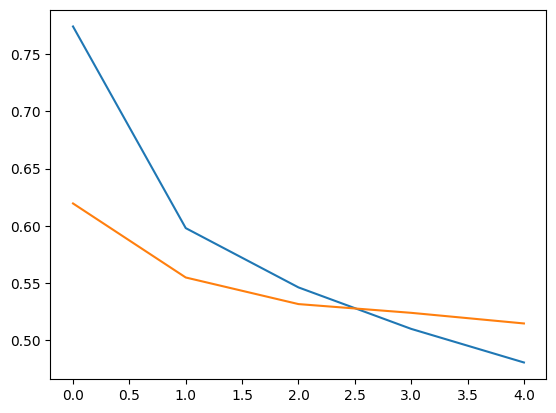

In [17]:
import seaborn

seaborn.lineplot(history.history['loss'])
seaborn.lineplot(history.history['val_loss'])

### Evaluation

In [18]:
%%time
from tqdm import tqdm
from transformers import pipeline, TextClassificationPipeline

print("Getting Test Prediction")
pipe = pipeline('sentiment-analysis',model=model,tokenizer=tokenizer,device=1)
prediction = []

for x in tqdm(pipe(data['test']['text'])):
  prediction.append(model.config.label2id[x['label']])

actual_labels = data['test']['labels']

Getting Test Prediction



100%|██████████| 7887/7887 [00:00<00:00, 706274.30it/s]

CPU times: user 25min 55s, sys: 9.65 s, total: 26min 4s
Wall time: 25min 56s


**Computing F1-Score, Precision, Recall and Accuracy of the Model**

In [19]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

print("F1-Score",f1_score(actual_labels,prediction,average='weighted'))
print("Precision-Score",precision_score(actual_labels,prediction,average='weighted'))
print("Recall-Score",recall_score(actual_labels,prediction,average='weighted'))
print("accuracy_Score",accuracy_score(actual_labels,prediction))

F1-Score 0.15880646182524677
Precision-Score 0.41290445005669846
Recall-Score 0.3106377583365031
accuracy_Score 0.3106377583365031


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**Plotting Confusion Matrix**

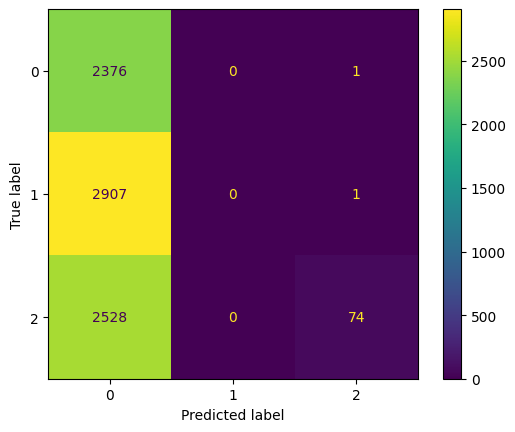

In [20]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cmd = ConfusionMatrixDisplay(tf.math.confusion_matrix(actual_labels,prediction,num_classes=3).numpy())
cmd.plot()

**Pushing Model to Huggingface Hub**